In [1]:
# based on clonealign framework, re-write with pyro
import logging
import sys

import os
from collections import defaultdict
import torch
import numpy as np
import pandas as pd
import scipy.stats
from torch.distributions import constraints
from torch.nn import Softplus
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.ops.indexing import Vindex

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.5.1')
pyro.enable_validation(True)

In [129]:
logging.basicConfig(format='%(relativeCreated) 9d %(message)s', level=logging.DEBUG)

# Add another handler for logging debugging events (e.g. for profiling)
# in a separate stream that can be captured.
log = logging.getLogger()
debug_handler = logging.StreamHandler(sys.stdout)
debug_handler.setLevel(logging.DEBUG)
debug_handler.addFilter(filter=lambda record: record.levelno <= logging.DEBUG)
log.addHandler(debug_handler)

In [130]:
# input data

expr_input = "data/SPECTRUM-OV-022_expr_clonealign_input.csv"
cnv_input = "data/SPECTRUM-OV-022_cnv_clonealign_input.csv"

clone_assign_prob_output = "data/SPECTRUM-OV-022_clone_assign_prob_0.csv"
gene_type_score_output = "data/SPECTRUM-OV-022_gene_type_score_0.csv"
gene_fold_change_output = "data/SPECTRUM-OV-022_gene_fold_change_0.csv"


In [131]:

expr_csv = pd.read_csv(expr_input, header = 0, index_col=0)
cnv_csv = pd.read_csv(cnv_input, header = 0, index_col=0)

expr_csv = expr_csv[expr_csv.mean(1) > 0]
cnv_csv = cnv_csv.loc[expr_csv.index, ]

# cast cnv greater than 6
cnv = torch.tensor(cnv_csv.values, dtype=torch.float)
cnv = torch.transpose(cnv, 0, 1)

cnv[cnv > 6] = 6

expr = torch.tensor(expr_csv.values, dtype = torch.float)
expr = torch.transpose(expr, 0, 1)



In [132]:
torch.min(cnv, 0)[0]

tensor([2., 2., 2.,  ..., 2., 2., 2.])

In [133]:
# input data: cnv, expr
# cnv: clone_count * gene_count
# expr: cell_count * gene_count
def inverse_softplus(x):
    return x + torch.log(-torch.expm1(-x))

@config_enumerate
def clonealign_pyro(cnv, expr, temperature):
    num_of_clones = len(cnv)
    num_of_cells = len(expr)
    num_of_genes = len(expr[0])

    softplus = Softplus()

    # initialize per_copy_expr using the data (This typically speeds up convergence)
    expr = expr * 3000 / torch.reshape(torch.sum(expr, 1), (num_of_cells, 1))
    per_copy_expr_guess = torch.mean(expr, 0)

    # calculate copy number mean
    # copy_number_mean = torch.mean(cnv, 0)
    
    cnv_min = torch.min(cnv, 0)[0]
    cnv_rel = cnv / cnv_min

    # draw chi from gamma
    chi = pyro.sample('expose_chi', dist.Gamma(torch.ones(6) * 2, torch.ones(6)).to_event(1))

    with pyro.plate('gene', num_of_genes):
        # draw per_copy_expr from softplus-transformed Normal distribution
        per_copy_expr = pyro.sample('expose_per_copy_expr',
                                    dist.Normal(inverse_softplus(per_copy_expr_guess), torch.ones(num_of_genes)))
        

        per_copy_expr = softplus(per_copy_expr)
        
        # instead of softplus-transformed normal, use negative binomial instead for per_copy_expr
        # per_copy_expr = pyro.sample('per_copy_expr', dist.NegativeBinomial())

        # draw w from Normal
        w = pyro.sample('expose_w', dist.Normal(torch.zeros(6), torch.sqrt(chi)).to_event(1))

        # sample the gene_type_score from uniform distribution.
        # the score reflects how much the copy number influence expression.
        # gene_type_score = pyro.sample('expose_gene_type_score', dist.Dirichlet(torch.ones(2)))
        # gene_type = pyro.sample('expose_gene_type', dist.RelaxedOneHotCategorical(temperature = torch.tensor([0.5]), probs = gene_type_score))
        
        # draw gene fold change 
        gene_fold_change = pyro.sample('expose_gene_fold_change', dist.Uniform(low = -1, high = 10))
        

    with pyro.plate('cell', num_of_cells):
        # draw clone_assign_prob from Dir
        clone_assign_prob = pyro.sample('expose_clone_assign_prob', dist.Dirichlet(torch.ones(num_of_clones) * 0.1))
        # draw clone_assign from Cat
        clone_assign = pyro.sample('clone_assign', dist.Categorical(clone_assign_prob))

        # draw psi from Normal
        psi = pyro.sample('expose_psi', dist.Normal(torch.zeros(6), torch.ones(6)).to_event(1))        

        # expected_expr = (per_copy_expr * torch.pow(Vindex(cnv)[clone_assign], gene_fold_change) + copy_number_mean * gene_type[:, 1]) * torch.exp(
        #    torch.matmul(psi, torch.transpose(w, 0, 1)))

        expected_expr = (per_copy_expr * torch.pow(Vindex(cnv_rel)[clone_assign], gene_fold_change) * cnv_min) * torch.exp(
            torch.matmul(psi, torch.transpose(w, 0, 1)))
        
        # draw expr from Multinomial
        pyro.sample('obs', dist.Multinomial(total_count = 3000, probs=expected_expr, validate_args=False), obs=expr)
        


In [134]:
# initialize Adam optimizer
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})

# TraceEnum_ELBO will marginalize out the assignments of datapoints to clusters
elbo = TraceEnum_ELBO(max_plate_nesting=2)

pyro.clear_param_store()

# AutoGuide
global_guide = AutoDelta(poutine.block(clonealign_pyro, expose_fn=lambda msg: msg["name"].startswith("expose_")))
# put together SVI object
svi = SVI(clonealign_pyro, global_guide, optim, loss=elbo)

In [135]:
tau0 = 1.0
ANNEAL_RATE=0.0003
MIN_TEMP=0.5
np_temp=tau0


gradient_norms = defaultdict(list)
svi.loss(clonealign_pyro, global_guide, cnv, expr, np_temp)  # Initializes param store.

27190126.0

In [136]:
losses = []
max_iter = 500
rel_tol = 1e-5
print('Start Inference.')
for i in range(max_iter if not smoke_test else 2):
    loss = svi.step(cnv, expr, np_temp)
    if i % 100 == 1:
        np_temp=np.maximum(tau0*np.exp(-ANNEAL_RATE*i),MIN_TEMP)
    
    if i >= 1:
        loss_diff = abs((losses[-1] - loss)/losses[-1])
        if loss_diff < rel_tol:
            print('ELBO converged at iteration ' + str(i))
            break
    
    losses.append(loss)
    
    print('.' if i % 500 else '\n', end='')

Start Inference.

.........................................................................................................................................................................................................................................................ELBO converged at iteration 250


In [137]:
losses

[27190126.0,
 24757712.0,
 22618438.0,
 20552006.0,
 18672514.0,
 17349504.0,
 16685700.0,
 16244817.0,
 15776851.0,
 15421738.0,
 15240682.0,
 15108831.0,
 14948823.0,
 14792893.0,
 14679831.0,
 14604555.0,
 14539506.0,
 14472601.0,
 14411282.0,
 14362701.0,
 14325078.0,
 14292008.0,
 14259801.0,
 14229143.0,
 14200570.0,
 14172881.0,
 14145768.0,
 14120043.0,
 14095745.0,
 14072087.0,
 14048909.0,
 14026980.0,
 14006603.0,
 13987464.0,
 13969576.0,
 13952906.0,
 13937443.0,
 13922993.0,
 13909634.0,
 13897238.0,
 13885603.0,
 13874632.0,
 13864184.0,
 13854322.0,
 13844865.0,
 13835801.0,
 13827129.0,
 13818746.0,
 13810608.0,
 13802812.0,
 13795177.0,
 13787784.0,
 13780635.0,
 13773713.0,
 13767011.0,
 13760580.0,
 13754425.0,
 13748570.0,
 13743037.0,
 13737818.0,
 13732947.0,
 13728366.0,
 13724051.0,
 13720026.0,
 13716154.0,
 13712446.0,
 13708964.0,
 13705613.0,
 13702397.0,
 13699314.0,
 13696346.0,
 13693490.0,
 13690708.0,
 13688005.0,
 13685349.0,
 13682761.0,
 13680266.0,

 14158856 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14158861 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14158872 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14158880 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14158888 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14158896 ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07,

 14159132 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159136 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159141 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159144 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159151 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159156 ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07,

 14159176 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159180 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159188 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159193 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159200 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159207 ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07,

 14159219 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159225 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159234 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159242 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159249 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159257 ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07,

 14159281 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159288 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159298 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159303 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159314 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159319 ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07,

 14159332 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159338 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159347 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159353 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159362 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159367 ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07,

 14159392 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159397 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159404 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159410 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159417 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159422 ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07,

 14159433 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159439 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159445 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159450 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159457 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159462 ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07,

 14159499 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159506 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159513 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159518 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159526 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159532 ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07,

 14159675 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159679 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159685 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159690 ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])
ticklocs array([1.e+06, 1.e+07, 1.e+08, 1.e+09])


 14159696 vmin 12862488.32227021 vmax 28176790.09172422


vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422
vmin 12862488.32227021 vmax 28176790.09172422


 14159702 ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])


ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07,
       2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08, 8.e+08, 9.e+08,
       2.e+09, 3.e+09, 4.e+09, 5.e+09, 6.e+09, 7.e+09, 8.e+09, 9.e+09])
ticklocs array([2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07,

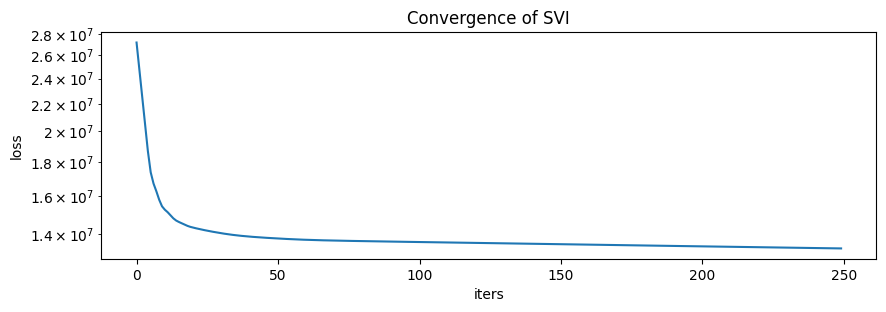

In [147]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
_ = pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

In [139]:
map_estimates = global_guide(cnv, expr)

clone_assign_prob = map_estimates['expose_clone_assign_prob']
# gene_type_score = map_estimates['expose_gene_type_score']

per_copy_expr = map_estimates['expose_per_copy_expr']
psi = map_estimates['expose_psi']
chi = map_estimates['expose_chi']
w = map_estimates['expose_w']

gene_fold_change = map_estimates['expose_gene_fold_change']

clone_assign_prob_dataframe = pd.DataFrame(clone_assign_prob.data.numpy())
# gene_type_score_dataframe = pd.DataFrame(gene_type_score.data.numpy())

gene_fold_change_dataframe = pd.DataFrame(gene_fold_change.data.numpy())

In [140]:
gene_fold_change_dataframe

,0
0,0.897863
1,2.616322
2,3.532978
3,5.413507
4,-0.961082
...,...
4054,2.234807
4055,2.926473
4056,1.923223
4057,3.436948


In [141]:
clone_assign_prob_dataframe

,0,1,2
0,2.333412e-23,2.333412e-23,1.000000e+00
1,1.000000e+00,2.333412e-23,2.333412e-23
2,1.000000e+00,2.333412e-23,2.333412e-23
3,1.000000e+00,2.333412e-23,2.333412e-23
4,1.000000e+00,2.333412e-23,2.333412e-23
...,...,...,...
5134,2.333412e-23,2.333412e-23,1.000000e+00
5135,2.333412e-23,2.333412e-23,1.000000e+00
5136,2.333412e-23,2.333412e-23,1.000000e+00
5137,2.333412e-23,1.000000e+00,2.333412e-23


In [142]:
rowname_dict = {i:c for i, c in enumerate(expr_csv.columns)}
colname_dict = {i:c for i, c in enumerate(cnv_csv.columns)}

genename_dict = {i:c for i, c in enumerate(expr_csv.index)}

clone_assign_prob_dataframe.rename(index = rowname_dict, inplace = True)
clone_assign_prob_dataframe.rename(columns = colname_dict, inplace = True)

# gene_type_score_dataframe.rename(index = genename_dict, inplace = True)
gene_fold_change_dataframe.rename(index = genename_dict, inplace = True)

In [143]:
clone_assign_prob_dataframe.to_csv(clone_assign_prob_output)

In [144]:
gene_type_score_dataframe.to_csv(gene_type_score_output)

In [145]:
gene_fold_change_dataframe.to_csv(gene_fold_change_output)

In [146]:
clone_assign_prob_dataframe

,cluster_1,cluster_2,cluster_3
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACCCACAAGCGCAA,2.333412e-23,2.333412e-23,1.000000e+00
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACCCATCGCGGACT,1.000000e+00,2.333412e-23,2.333412e-23
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACGAATCCTTGGAA,1.000000e+00,2.333412e-23,2.333412e-23
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACGCTCACTATCGA,1.000000e+00,2.333412e-23,2.333412e-23
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACGCTGTCGACTTA,1.000000e+00,2.333412e-23,2.333412e-23
...,...,...,...
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGATCCATGACTGT,2.333412e-23,2.333412e-23,1.000000e+00
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGATCGTTCAAGTC,2.333412e-23,2.333412e-23,1.000000e+00
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGGAGTCCATTGCC,2.333412e-23,2.333412e-23,1.000000e+00
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGTTGGTGTCTAAC,2.333412e-23,1.000000e+00,2.333412e-23


In [59]:
clone_assign_prob_dataframe

,cluster_1,cluster_2,cluster_3
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACCCACAAGCGCAA,1.254433e-16,1.254433e-16,1.0
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACCCATCGCGGACT,1.254433e-16,1.254433e-16,1.0
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACGAATCCTTGGAA,1.254433e-16,1.254433e-16,1.0
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACGCTCACTATCGA,1.254433e-16,1.254433e-16,1.0
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACGCTGTCGACTTA,1.254433e-16,1.254433e-16,1.0
...,...,...,...
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGATCCATGACTGT,1.254433e-16,1.254433e-16,1.0
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGATCGTTCAAGTC,1.254433e-16,1.254433e-16,1.0
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGGAGTCCATTGCC,1.254429e-16,1.254429e-16,1.0
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGTTGGTGTCTAAC,1.254429e-16,1.254429e-16,1.0


In [3]:
torch.tensor([0.5])

tensor([0.5000])